Dict: ANOVA,SSM,SSR,SSE

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import scipy.stats

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving train.csv to train.csv


# Описание данных

**Описание столбцов**
* SalePrice - цена дома, прогназируемое значение
* MSSubClass - класс дома (рейтинг здания который присвоили эксперты)
* LotArea - площадь дома
* LotShape - форма площади( Reg - прямоугольная, IR1,IR2 - нестандартная)
* YearBuilt - год постройки
* BedroomAbvGr - количество спален

остальные переменные в датасете - 
количество ванн, материал крыши, или высота подвала я счел не важным для модели.

In [ ]:
data=pd.read_csv("train.csv")
data=data.iloc[:,1:]


#data
data.head(5)

,SalePrice,MSSubClass,LotArea,LotShape,YearBuilt,BedroomAbvGr
0,208500,60,8450,Reg,2003,3
1,181500,20,9600,Reg,1976,3
2,223500,60,11250,IR1,2001,3
3,140000,70,9550,IR1,1915,3
4,250000,60,14260,IR1,2000,4


# One hot encoding категориальных переменных в конец таблицы

**Все полностью автоматизиривано: неважно сколько столбцов в таблице и сколько разных значений фиктивной переменной**

In [ ]:
tmp=pd.get_dummies(data.loc[:,"LotShape"])
unq=data.loc[:,"LotShape"].unique()# Создаем список всевозможных значенй переменной чтобы потом назвать столбцы
cnt=0

for i in tmp.columns:
  #display(tmp[i])
  print(i)
  data.insert(len(data.columns),unq[cnt],tmp[i]) #добавление столбцов в конец таблицы
  cnt+=1

del data["LotShape"]

data.head(5)

IR1
IR2
Reg


,SalePrice,MSSubClass,LotArea,YearBuilt,BedroomAbvGr,Reg,IR1,IR2
0,208500,60,8450,2003,3,0,0,1
1,181500,20,9600,1976,3,0,0,1
2,223500,60,11250,2001,3,1,0,0
3,140000,70,9550,1915,3,1,0,0
4,250000,60,14260,2000,4,1,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     50 non-null     int64
 1   MSSubClass    50 non-null     int64
 2   LotArea       50 non-null     int64
 3   YearBuilt     50 non-null     int64
 4   BedroomAbvGr  50 non-null     int64
 5   Reg           50 non-null     uint8
 6   IR1           50 non-null     uint8
 7   IR2           50 non-null     uint8
dtypes: int64(5), uint8(3)
memory usage: 2.2 KB


In [ ]:
import plotly.express as px

Y=data.iloc[:,0]
X=data.iloc[:,2]

fig = px.scatter(x=X, y=Y)
fig.show()

# Корреляционная матрица

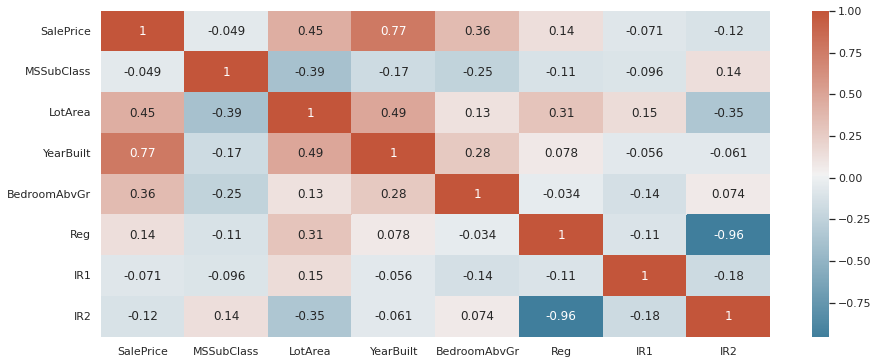

In [ ]:
rgsrs=data
corr_matrix=rgsrs.corr()

sns.set(rc={"figure.figsize":(15, 6)})#Задаем размер окна
cmap = sns.diverging_palette(230, 20, as_cmap=True)#Задаем палитру
sns.heatmap(corr_matrix, annot=True, cmap=cmap)

Хоть здесь присутствует сильная корреляция между Reg и IR2, однако она между двумя столбцами одной и той же категориалной переменной. Поэтому её не считаем.

также заметим, что оцениваемое значение имеет сильный коэф. коррел. с YearBuilt

**В целом мультколлинерности между факторами нет**

На всякий случай проверим другим способом - определитель матрицы $det(X^T*X)$

In [ ]:
tmp=np.array(data.iloc[:,1:])
tmp=sm.add_constant(tmp)

XTX_wc=np.matmul(tmp.transpose(),tmp)
np.linalg.det(XTX_wc)

82942471.42703168

Совсем не около нуля

#Первая модель со всеми факторами

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X1=data.iloc[:,1:]
model.fit(X1, Y)

a=model.intercept_


b=model.coef_

model.score(X1,Y)

0.6569862297537896

In [ ]:
a,b

(-3345854.513282853,
 array([ 3.13624477e+02,  3.52789751e+00,  1.73332078e+03,  2.04785142e+04,
         7.11375339e+03, -3.90014016e+03, -3.21361322e+03]))

In [ ]:

#print(X1)
x4_m=sm.add_constant(X1)

model=sm.OLS(Y, x4_m).fit()

model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     13.73
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.22e-08
Time:                        11:28:40   Log-Likelihood:                -603.34
No. Observations:                  50   AIC:                             1221.
Df Residuals:                      43   BIC:                             1234.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.509e+06   3.93e+05     -6.378      0.000    -3.3e+06   -1.72e+06
MSSubClass     313.6245    174.768      1.795      0.080     -38.829     666.078
LotArea          3.5279      2.960      1.192      0.240      -2.441       9.497
YearBuilt     1733.3208    276.443      6.270      0.000    1175.820    2290.822
BedroomAbvGr  2.048e+04   9551.473      2.144      0.038    1216.134    3.97e+04
Reg          -8.293e+05   1.33e+05     -6.231      0.000    -1.1e+06   -5.61e+05
IR1          -8.404e+05   1.32e+05     -6.360      0.000   -1.11e+06   -5.74e+05
IR2          -8.397e+05   1.34e+05     -6.254      0.000   -1.11e+06   -5.69e+05
==============================================================================
Omnibus:                        1.578   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.116
Skew:                           0.017   Prob(JB):                        0.572
Kurtosis:                       2.269   Cond. No.                     1.97e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.42e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
np.array(model.params)

array([-2.50939088e+06,  3.13624477e+02,  3.52789751e+00,  1.73332078e+03,
        2.04785142e+04, -8.29349875e+05, -8.40363768e+05, -8.39677242e+05])

Видим что почти все коэффиценты почти нулевые кроме свободного и второго. Что пошло не так?/

Заметим что как раз второй признак гораздо больше численно чем другие.

Поэтому сделаем все данные чтобы было примерно одного порядка

#Вторая модель (первая, но со станд. данными)

В данной модели попробуем преобразовать данные: стандартизировать регресоры

BoxPlot данных смотрим что не так

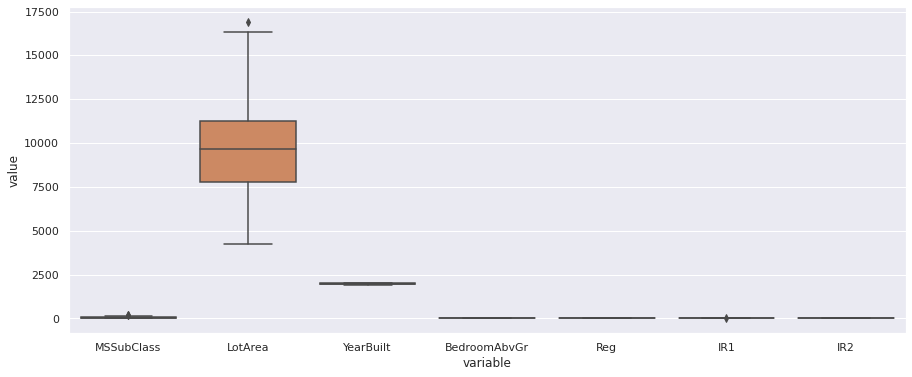

In [ ]:
#X1.boxplot()

sns.boxplot(x="variable", y="value", data=pd.melt(X1))

Видим что второй сильно перевешивает Посмотрим как выглядит картина без второго и третьего признака.

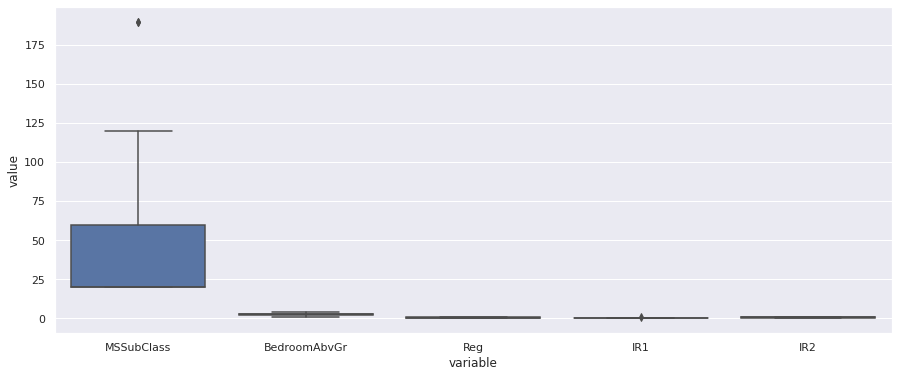

In [ ]:
X1_exceptLA=X1.loc[:, ~X1.columns.isin(['const','LotArea','YearBuilt'])]

sns.boxplot(x="variable", y="value", data=pd.melt(X1_exceptLA))

Выглядит все равно очень плохо. Преобразуем данные к одному виду, а именно с помощью стандартизации

In [ ]:
scaler = StandardScaler().fit(X1)
X_std = scaler.transform(X1)

dX_std=pd.DataFrame(X_std)
dX_std=dX_std.set_axis(X1.columns,axis=1)

data.head(3)

,SalePrice,MSSubClass,LotArea,YearBuilt,BedroomAbvGr,Reg,IR1,IR2
0,208500,60,8450,2003,3,0,0,1
1,181500,20,9600,1976,3,0,0,1
2,223500,60,11250,2001,3,1,0,0


Получаем

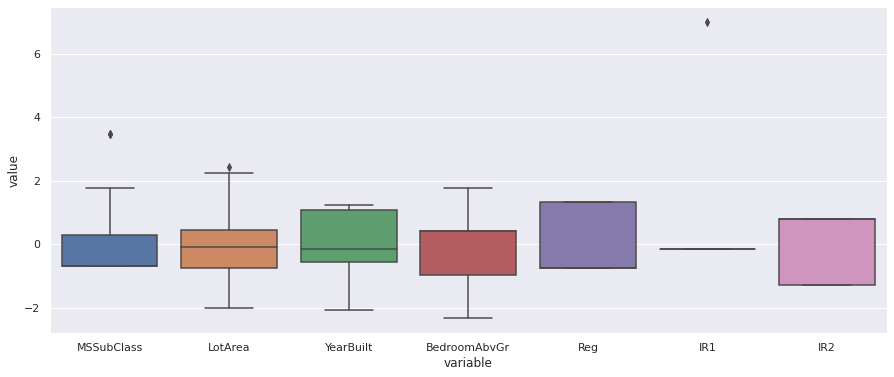

In [ ]:
sns.boxplot(x="variable", y="value", data=pd.melt(dX_std))

Корреляционная матрица будет такая же Поэтому сразу перейдем к модели

In [ ]:
x_4m = sm.add_constant(X_std)

model2=sm.OLS(Y, x_4m).fit()


model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     13.73
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.22e-08
Time:                        15:32:47   Log-Likelihood:                -603.34
No. Observations:                  50   AIC:                             1221.
Df Residuals:                      43   BIC:                             1234.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.796e+05   6420.630     27.978      0.000    1.67e+05    1.93e+05
x1          1.287e+04   7174.540      1.795      0.080   -1593.990    2.73e+04
x2          1.008e+04   8457.746      1.192      0.240   -6975.830    2.71e+04
x3          4.827e+04   7697.737      6.270      0.000    3.27e+04    6.38e+04
x4          1.491e+04   6953.577      2.144      0.038     885.359    2.89e+04
x5          2618.4513   3574.270      0.733      0.468   -4589.751    9826.654
x6          -778.2301   6380.165     -0.122      0.903   -1.36e+04    1.21e+04
x7         -2364.9288   3616.363     -0.654      0.517   -9658.020    4928.163
==============================================================================
Omnibus:                        1.578   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.116
Skew:                           0.017   Prob(JB):                        0.572
Kurtosis:                       2.269   Cond. No.                     8.76e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.53e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

В любом случае коэффицент детерминации оказался тот же. Нормализация не дала каких-либо улучшений. Надо было изначально посмотреть на $R'~^2$, а не на коэффиценты модели.

# Третья модель (усложнение модели)

Попробуем усложнить модель добавив еще одну зависимость для фиктивных переменных вида $y=b_0+b_1*x+b_2*d_1+b_3*d_1*x,$\
где $x$ - численная переменная, $d_1$ - фиктивная переменная в формате one-hot encodding, $b_i$ - коэффиценты модели

In [ ]:
dX_std.head(5)

,MSSubClass,LotArea,YearBuilt,BedroomAbvGr,Reg,IR1,IR2
0,0.304493,-0.515296,1.078086,0.412082,-0.750000,-0.142857,0.782881
1,-0.669885,-0.112841,0.108455,0.412082,-0.750000,-0.142857,0.782881
2,0.304493,0.464594,1.006262,0.412082,1.333333,-0.142857,-1.277333
3,0.548088,-0.130339,-2.082193,0.412082,1.333333,-0.142857,-1.277333
4,0.304493,1.517975,0.970349,1.785687,1.333333,-0.142857,-1.277333


In [ ]:
dX_std["Reg*LotArea"]=dX_std['LotArea']*dX_std['Reg']
dX_std["IR1*LotArea"]=dX_std['LotArea']*dX_std['IR1']
dX_std["IR2*LotArea"]=dX_std['LotArea']*dX_std['IR2']

dX_std.head(5)

,MSSubClass,LotArea,YearBuilt,BedroomAbvGr,Reg,IR1,IR2,Reg*LotArea,IR1*LotArea,IR2*LotArea
0,0.304493,-0.515296,1.078086,0.412082,-0.750000,-0.142857,0.782881,0.386472,0.073614,-0.403416
1,-0.669885,-0.112841,0.108455,0.412082,-0.750000,-0.142857,0.782881,0.084631,0.016120,-0.088341
2,0.304493,0.464594,1.006262,0.412082,1.333333,-0.142857,-1.277333,0.619458,-0.066371,-0.593441
3,0.548088,-0.130339,-2.082193,0.412082,1.333333,-0.142857,-1.277333,-0.173786,0.018620,0.166487
4,0.304493,1.517975,0.970349,1.785687,1.333333,-0.142857,-1.277333,2.023967,-0.216854,-1.938960


In [ ]:
dX_std

dX_std_4m = sm.add_constant(dX_std)

model3=sm.OLS(Y, dX_std_4m).fit()


model3.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     11.85
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.21e-08
Time:                        11:28:53   Log-Likelihood:                -602.83
No. Observations:                  50   AIC:                             1222.
Df Residuals:                      42   BIC:                             1237.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.755e+05   6840.979     25.656      0.000    1.62e+05    1.89e+05
MSSubClass    1.059e+04   7593.808      1.394      0.171   -4737.281    2.59e+04
LotArea       1.181e+04   8320.011      1.419      0.163   -4980.286    2.86e+04
YearBuilt     4.844e+04   7711.860      6.281      0.000    3.29e+04     6.4e+04
BedroomAbvGr  1.467e+04   6969.244      2.104      0.041     600.655    2.87e+04
Reg           3641.2438   3624.010      1.005      0.321   -3672.304     1.1e+04
IR1          -1.292e+04   3055.944     -4.228      0.000   -1.91e+04   -6754.779
IR2            126.2339   3561.690      0.035      0.972   -7061.548    7314.016
Reg*LotArea   1957.9607   3912.067      0.500      0.619   -5936.910    9852.831
IR1*LotArea   1.126e+04   3305.242      3.408      0.001    4594.193    1.79e+04
IR2*LotArea  -5185.2350   3798.136     -1.365      0.179   -1.29e+04    2479.714
==============================================================================
Omnibus:                        1.781   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.191
Skew:                           0.021   Prob(JB):                        0.551
Kurtosis:                       2.245   Cond. No.                     1.56e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.01e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
print("Было: ",model2.rsquared_adj)
print("Стало: ",model3.rsquared_adj)

Было:  0.6091238432078067
Стало:  0.6079128983005084


Смещенный коэффицент детерминации незначтельно уменшился $=>$ нет смысла в усложнеии модели такм образом

In [ ]:
model2.params

const    179637.720000
x1        12874.848240
x2        10080.839832
x3        48265.424222
x4        14908.583339
x5         2618.451288
x6         -778.230138
x7        -2364.928838
dtype: float64

# Проверка значимости коэффицентов и регрессии

In [ ]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     13.73
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.22e-08
Time:                        11:28:54   Log-Likelihood:                -603.34
No. Observations:                  50   AIC:                             1221.
Df Residuals:                      43   BIC:                             1234.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.796e+05   6420.630     27.978      0.000    1.67e+05    1.93e+05
x1          1.287e+04   7174.540      1.795      0.080   -1593.990    2.73e+04
x2          1.008e+04   8457.746      1.192      0.240   -6975.830    2.71e+04
x3          4.827e+04   7697.737      6.270      0.000    3.27e+04    6.38e+04
x4          1.491e+04   6953.577      2.144      0.038     885.359    2.89e+04
x5          2618.4513   3574.270      0.733      0.468   -4589.751    9826.654
x6          -778.2301   6380.165     -0.122      0.903   -1.36e+04    1.21e+04
x7         -2364.9288   3616.363     -0.654      0.517   -9658.020    4928.163
==============================================================================
Omnibus:                        1.578   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.116
Skew:                           0.017   Prob(JB):                        0.572
Kurtosis:                       2.269   Cond. No.                     8.76e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.53e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
np.array((model2.params))/np.array(model2.bse)

array([27.97820559,  1.79451904,  1.19190621,  6.27007981,  2.14401639,
        0.73258354, -0.1219765 , -0.65395224])

In [ ]:
R=model2.rsquared

n=len(data)
k=len(data.columns)-1

F=(n-k)/(k-1)*(R/(1-R))
F

13.726566457830154

In [ ]:
t=scipy.stats.f.ppf(1-0.05,k,n-k-1)
t

2.237070295093028

$F_{statistic} > f_{critic} =>$ $H_0$ гипотеза отклоняется. Регрессия значима 

Проверка значимости коэффицентов

Строим матрицу $(X^T*X)^{-1}$

In [ ]:
XTXi_wc=np.linalg.inv(XTX_wc)# Обратная матрица от произведения с константой

Считаем RMSD

In [ ]:
X_std_wc=sm.add_constant(X_std)

ESS=sum(((Y-model2.predict(X_std_wc))**2))

RMSD=(ESS/(n-k))**0.5

RMSD

45400.71361965402

In [ ]:
mb_i=np.array([])
for i in range(len(XTXi_wc)):
  mb_i=np.append(mb_i,((XTXi_wc[i][i])**0.5))

mb_i=RMSD/mb_i

mb_i=np.array(model2.bse)

mb_i

array([6420.63049423, 7174.53978973, 8457.74590332, 7697.73681636,
       6953.57713114, 3574.26991214, 6380.16464971, 3616.3632193 ])

Посчитаем статистику для коэффицентов

In [ ]:
b_i=np.array(model2.params)

#print(b_i)

t=b_i/mb_i # t статистика всех коэффицентов

t

array([27.97820559,  1.79451904,  1.19190621,  6.27007981,  2.14401639,
        0.73258354, -0.1219765 , -0.65395224])

Проверяем с $t$ student critic value, two tailed

In [ ]:
tc=scipy.stats.t.ppf(1-0.05/2,n-k) #two tailed
tc

2.0166921941428133

In [ ]:

print(t)
print(t>tc)

[27.97820559  1.79451904  1.19190621  6.27007981  2.14401639  0.73258354
 -0.1219765  -0.65395224]
[ True False False  True  True False False False]


Значимые переменные те у которых статистика больше critic value

По итогам теста остаются переменные

In [ ]:
col=pd.Series(x4_m.columns)
col_n=col.mask(t<tc).dropna()

display(col_n)

0           const
3       YearBuilt
4    BedroomAbvGr
dtype: object

# Четвертая модель (на основе значимости коэфицентов)

In [ ]:
Xn_wc=pd.DataFrame(x4_m,columns=col_n)#Строим новую таблицу на основе гипотезы

model4=sm.OLS(Y, Xn_wc).fit()

model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     38.41
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.30e-10
Time:                        11:28:57   Log-Likelihood:                -605.87
No. Observations:                  50   AIC:                             1218.
Df Residuals:                      47   BIC:                             1223.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.565e+06    4.7e+05     -7.585      0.000   -4.51e+06   -2.62e+06
YearBuilt     1875.7937    241.381      7.771      0.000    1390.197    2361.391
BedroomAbvGr  1.617e+04   9232.581      1.752      0.086   -2402.452    3.47e+04
==============================================================================
Omnibus:                        2.630   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                1.533
Skew:                           0.118   Prob(JB):                        0.465
Kurtosis:                       2.175   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Видим, что коэффицент исправленный коэфицент детерминации уменьшился на 0.005. С другой стороны мы значительно уменьшили количество факторов с 6 до 2!\
Также аргумент в пользу этой модели коэффицент Акаике также уменьшился.

# Пятая модель - Отбор факторов с помощью поэтапного включения переменных

Проводим отбор с помощью скорректироанного коэффицента дерминации с шагом 0.1, то есть если с новым фактором $R^{ '2}$ стал больше на 0.1 добавляем этот регрессор

Сначала найдем какой из факторов в одиночку даёт наилучший $R^2$:

In [ ]:
#for i in range(len(X.columns)):
X_strt=sm.add_constant(X1)

max_i=0
maxi=0
for i in range(1,len(X_strt.columns)):
  tmp=sm.add_constant(X_strt.iloc[:,i])
  model_st=sm.OLS(Y, tmp).fit()
  if (maxi<model_st.rsquared):
    maxi=model_st.rsquared
    max_i=i

X_strt.columns[max_i]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



'YearBuilt'

C этим фактором и начнем подбор. На самом деле предсказуемо, что именно этот коэффицент имеет наивысший $R^2$, т.к. у этого фактора корреляция гораздо больше, чем у любой другой переменной.

Сам процесс:

In [ ]:
X_i=X_strt[X_strt.columns[max_i]]
X_i=sm.add_constant(X_i)


for i in range(1,len(X_strt.columns)):
  if i==max_i:#пропускаем фактор который уже есть
    continue
  else:
    tmp=X_i.copy()
    tmp.insert(len(X_i.columns),i,X_strt.iloc[:,i])#добавляем в конец новый фактор и смотрим на скоректированный коэффицент детерминации

    model_it=sm.OLS(Y, tmp).fit()
    print(model_it.rsquared_adj)
    if model_it.rsquared_adj-maxi>0.1:
      X_i=tmp


model5=sm.OLS(Y, X_i).fit()

print("------------")
print(X_i.head(2))
print("К. детерминации -",model5.rsquared_adj)
print()

0.5858936267317969
0.5849572418782218
0.6042611727556191
0.5846900807669586
0.579212066546039
0.5833412657083912
------------
   const  YearBuilt
0    1.0       2003
1    1.0       1976
К. детерминации - 0.5872127171300241



Как видим, при шаге 0.1 факторы не добавились. А модель остается зависимой только от YearBuilt

# Выбираем итоговую модель

Рассмотрим модели - 1,4,5 (Чем какая отличается см. оглвление)\

1 - имеет самую лучшую точность - 0.609, однако грамоздкая - 7 факторов\
5 - имеет точность меньше - 0.58, однако зависит только от одного фактора\
4 - находится между 1 и 5. Точность немного меньше 1 - 0.604, фактора всего 2\

Я выберу модель 4, потому что она имеет второй по показателю $R^{'2}$, но по сравнению с первой имеет гораздо меньше регрессеров



ANOVA TEST

In [ ]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     38.41
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.30e-10
Time:                        11:56:26   Log-Likelihood:                -605.87
No. Observations:                  50   AIC:                             1218.
Df Residuals:                      47   BIC:                             1223.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.565e+06    4.7e+05     -7.585      0.000   -4.51e+06   -2.62e+06
YearBuilt     1875.7937    241.381      7.771      0.000    1390.197    2361.391
BedroomAbvGr  1.617e+04   9232.581      1.752      0.086   -2402.452    3.47e+04
==============================================================================
Omnibus:                        2.630   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                1.533
Skew:                           0.118   Prob(JB):                        0.465
Kurtosis:                       2.175   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Анализ модели 4

Выведем графики прогнозируемых значений

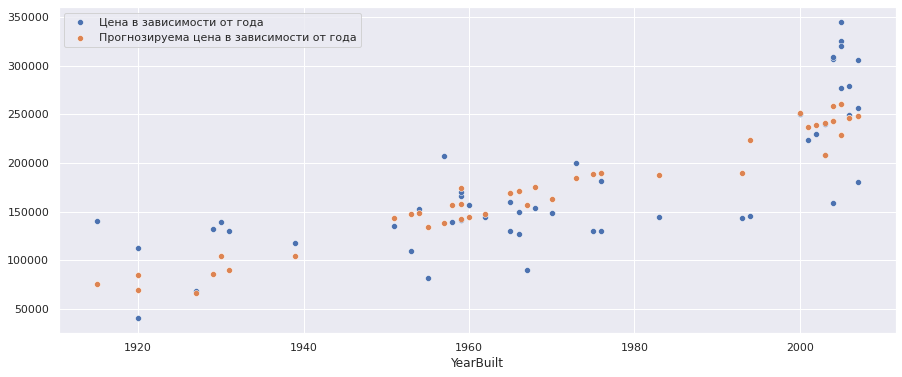

In [ ]:
n=len(Xn_wc)
k=len(Xn_wc.columns)-1

y_p=model4.predict(Xn_wc)

tmp=np.array(X1.iloc[:,1]).sort()

sns.scatterplot(x=Xn_wc.iloc[:,1],y=np.array(Y),label="Цена в зависимости от года")
sns.scatterplot(x=Xn_wc.iloc[:,1],y=(np.array(y_p)),label="Прогнозируема цена в зависимости от года")

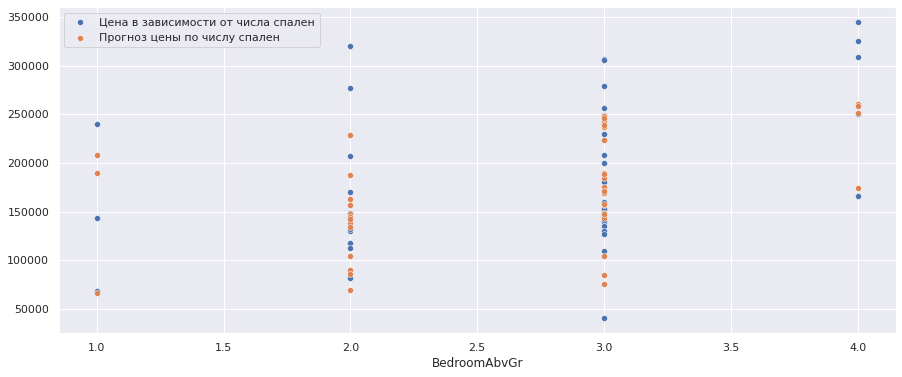

In [ ]:
sns.scatterplot(x=Xn_wc.iloc[:,2],y=np.array(Y),label="Цена в зависимости от числа спален")
sns.scatterplot(x=Xn_wc.iloc[:,2],y=np.array(y_p),label="Прогноз цены по числу спален")

## Доверительные интервалы параметров

In [ ]:
b_i=model4.params
ESS=sum((Y-y_p)**2)


sbj=1/(mb_i/RMSD)#вектор диагональных элементов матрицы (X^T*X)^-1

s2=1/(n-k-1)*ESS# несмещенная оценка дисперсии

sbj=(s2**0.5)*sbj

for i in range(len(b_i)):
  print(b_i[i]-(scipy.stats.t.ppf(1-0.05/2,n-k-1))*sbj[i],"< ", end=" ") # student citic value, two tails
  print("b_{i} < ".format(i=i), end=" ")
  print(b_i[i]+(scipy.stats.t.ppf(1-0.05/2,n-k-1))*sbj[i]) # student citic value, two tails



-4214764.697951465 <  b_0 <  -2915090.850629141
-579675.4821193822 <  b_1 <  583427.0695755064
-477147.4236338549 <  b_2 <  509489.6345214794


## Стандартизириованные коэффиценты регрессии

In [ ]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     38.41
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.30e-10
Time:                        11:29:23   Log-Likelihood:                -605.87
No. Observations:                  50   AIC:                             1218.
Df Residuals:                      47   BIC:                             1223.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.565e+06    4.7e+05     -7.585      0.000   -4.51e+06   -2.62e+06
YearBuilt     1875.7937    241.381      7.771      0.000    1390.197    2361.391
BedroomAbvGr  1.617e+04   9232.581      1.752      0.086   -2402.452    3.47e+04
==============================================================================
Omnibus:                        2.630   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                1.533
Skew:                           0.118   Prob(JB):                        0.465
Kurtosis:                       2.175   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
sig_Y=np.std(Y, ddof=1) # STDEV, стандотклон.в 

stdb_i=np.zeros([len(Xn_wc.columns)])

for i in range(0,len(Xn_wc.columns)):
  stdb_i[i]=np.std(Xn_wc.iloc[:,i], ddof=1) # STDEV, стандотклон.в




print("Коэффицент был, Стандартизированный")

for i in range(len(stdb_i)):
  print(b_i[i],stdb_i[i])

Коэффицент был, Стандартизированный
-3564927.7742903032 0.0
1875.7937280621247 28.12834288523566
16171.105443812286 0.7354021529276429


Про анализируем станд. коэффиценты. Можем сделат вывод, что второй коэффицент - 'YearBuild' вносит гораздо больше влияния. чем второй (28.12>0.7)

## Проверка влияния факторов на целевую переменную для модели 4 - постройка матрицы коррелляции.

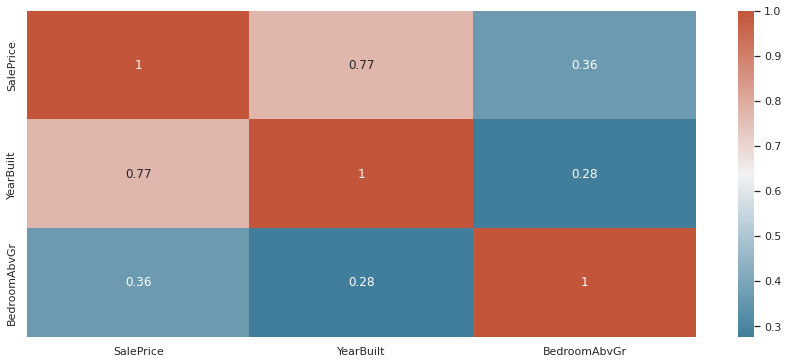

In [ ]:
rgsrs_4=Xn_wc.iloc[:,1:]
rgsrs_4.insert(0,"SalePrice",Y)
corr_matrix4=rgsrs_4.corr()

sns.set(rc={"figure.figsize":(15, 6)})#Задаем размер окна
cmap = sns.diverging_palette(230, 20, as_cmap=True)#Задаем палитру
sns.heatmap(corr_matrix4, annot=True, cmap=cmap)

Подтверждение предыдущего вывода - YearBuilt вносит достаточно много влияние на целевю переменную

## Вычисление метрик

In [ ]:
TSS=sum((Y-Y.mean())**2)



Коэффицент дериминации

In [ ]:
R=1-ESS/TSS

R #Показывает долю обьсненности модели
#Какая доля дисперсии результативного признака объясняется влиянием независимых переменных.
#Показатели R в разных моделях с разным числом  переменных несравнимы

0.6204137779492674

Исправленный коэф детерминации

In [ ]:
n=len(Xn_wc)
k=len(Xn_wc.columns)-1

R_adj=1-(n-1)*(1-R)/(n-k-1)

R_adj#Показывает насколько точно считает модель, но это уже истинный коэффицент при числе факторов k>1

0.6042611727556193

Средняя ошибка аппроксимации

In [ ]:
AA=abs((e)/Y)#среднее отклонение расчетных значений от фактических относительное значение
AA=(AA.sum())/n*100
AA

24.00398812619253

24% - не самый лучший показатель, и говорит, что ошибка, вообще говоря, существенная.

Среднее абсолютное отклонение

In [ ]:
MAD=sum(abs(Y-y_p))/n#среднее отклонение расчетных значений от фактических

MAD

36532.32904586604

Весьма неплохое значние - согласуется c A, так как данные порядка $10^5$, то $36,000$ Как раз примерно будут около 24% от исходных данных

## Тест на остатки (Теорема Гаусса-Маркова)

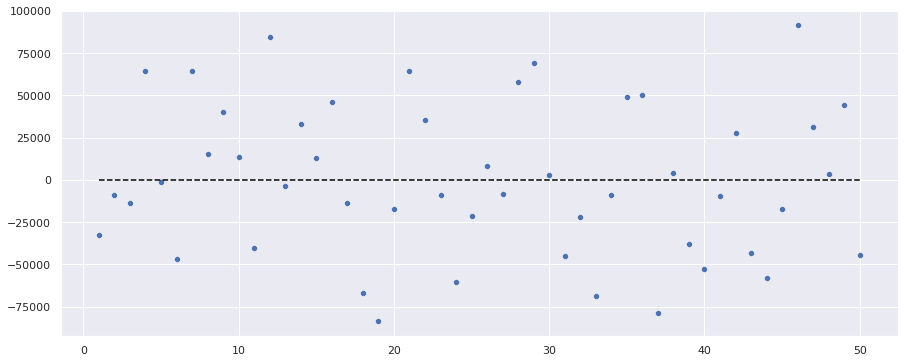

In [ ]:
xx=[i+1 for i in range(len(Y))]

fig = sns.scatterplot(x=xx, y=(Y-y_p))
fig = sns.lineplot(x=xx, y=0,color='black',linestyle='--')

**Анализ графика:**
* Точки находятся в трубке и никуда "не разабредаются" - гомоскедантичность
* Симметрично относительно 0 - матожидание 0
* Автокорреляции на первый взгляд нет - никакой зависимотси у точек не наблюдается
* Нормальное распраделение - вот здесь как раз подозрительно, т.к. нельзя сказать, что точек больше вблизи 0, чем в остальной плоскости. 

В первую очередь я проверирил бы тест на нормальное распределене

## Теорема Гаусса-Марков

### Тест Стьюдента на мат ожидание

In [ ]:
e=Y-y_p

t=e.mean()*(n**0.5)/(np.std(e, ddof=1))#t статистика

print(abs(t))

scipy.stats.t.ppf(1-0.05/2,n-1) # student citic value, two tails

1.250219581316487e-13


2.009575234489209

$|t^{~}| < t_{стьюд}$

Принимаем нулевую гипотезу - мат.ожидание 0

### Тест Колмогорова-Смирнова на нормальное распределение

Используя p-value


In [ ]:
Xn_wc.head()

,const,YearBuilt,BedroomAbvGr
0,1.0,2003,3
1,1.0,1976,3
2,1.0,2001,3
3,1.0,1915,3
4,1.0,2000,4


In [ ]:
from scipy.stats import kstest

kstest(e, 'norm')

KstestResult(statistic=0.54, pvalue=3.561199696487989e-14)

p_valu гораздо меньше уровня значимости - 0.05. Из чего есть основания полагать, что **остатки не распределены нормально**

### Тест Гольдфильда на гомоскедантичность

In [ ]:
rgsrs_4_sortY=rgsrs_4.sort_values(by=['SalePrice'], ignore_index=True) #Сортируем по целевой переменной
rgsrs_4_sortY.head(5)

,SalePrice,YearBuilt,BedroomAbvGr
0,40000,1920,3
1,68500,1927,1
2,82000,1955,2
3,90000,1967,2
4,109000,1953,3


In [ ]:
n_gold=int(len(rgsrs_4_sortY)/3) #размер крайних выборок
n_gold2=len(rgsrs_4_sortY)-2*n_gold #размер средней выборки

In [ ]:
rgsrs_4_sortY.head(3)

,SalePrice,YearBuilt,BedroomAbvGr
0,40000,1920,3
1,68500,1927,1
2,82000,1955,2


In [ ]:
gold1=rgsrs_4_sortY.iloc[:n_gold,1:]
gold2=rgsrs_4_sortY.iloc[n_gold+n_gold2:,1:]
Ygold1=rgsrs_4_sortY.loc[:n_gold-1,'SalePrice']
Ygold2=rgsrs_4_sortY.loc[n_gold+n_gold2:,'SalePrice']

gold_k=len(gold1.columns)
gold_k

2

In [ ]:
gold1 = sm.add_constant(gold1)

modelgold1=sm.OLS(Ygold1, gold1).fit()


gold2 = sm.add_constant(gold2)

modelgold2=sm.OLS(Ygold2, gold2).fit()


modelgold2.ssr/modelgold1.ssr#Статистика

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



2.0509953565589933

In [ ]:
F=scipy.stats.f.ppf(1-0.05,gold_k,n_gold2-gold_k-1)#крит точка распред Фишера
F

3.6823203436732412


$\frac{ESS_2}{ESS_1}<F$ **- есть гомоскедантичность**

### Тест на автокорелляцию Дарбина-Уотсона

Первого порядка

In [ ]:
dl=1.46
du=1.63


print("dl",dl)
print("du",du)
print("4-du",4-du)
print("4-dl",4-dl)



dl 1.46
du 1.63
4-du 2.37
4-dl 2.54


In [ ]:
durbin_watson(model4.resid)#статистика

1.6940224398186219

Статистика по критерию Дарбина-Уотсона находится между $d_u$ и $4-d_u$ - что говорит о том, что **корелляции первого порядка нет**.

Высших порядков до 12 порядка (продажный год)

In [ ]:
corr_vect=np.array([])
n=len(e)

for i in range(1,13):
  a=e[:n-i]
  b=e[i:]
  corr_vect=np.append(corr_vect,np.corrcoef(a,b)[0][1])
  

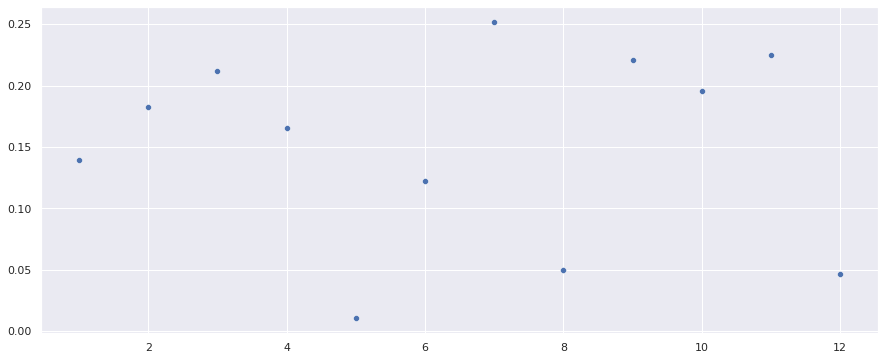

In [ ]:
xx=[i for i in range(1,len(corr_vect)+1)]

sns.scatterplot(x=xx,y=abs(corr_vect))

Проверим максимальный элемент среди различных порядков - в нашем случае - 7

In [ ]:
ts=(corr_vect[6]*((n-k)**0.5))/((1-corr_vect[6]**2)**0.5)
ts#Статистика

1.801795061935136

In [ ]:
t=scipy.stats.t.ppf(1-0.05/2,n-k)#two tailed
t

2.0106347546964454

Статистика меньше крит. точки стьюдента -** нет автокорреляции 7 порядка**

А следовательно **НЕТ АВТОКОРЕЛЛЯЦИИ ДО 12 ПОРЯДКА**

### Вывод

Все пункты теоремы Гаусса-Маркова выполнены, кроме, как и предполагалось, нормальности остатков./

Как можно это исправить? Может помочь переход к логарифмической или полулогарифмический модели:

$ln(y)=b_1*ln(x_1)+b_2*ln(x_2)+...$

$ln(y)=b_1*x_1+b_2*x_2+...$





# Прогноз значений для X, превышающее среднее на 45%

In [ ]:
x4mean=rgsrs_4.iloc[:,1:].mean()#Среднее

x4mean

YearBuilt       1972.98
BedroomAbvGr       2.70
dtype: float64

In [ ]:
x4mean1=np.array([1.0,1972.98,2.70])
x4mean1=x4mean1.reshape(1,3)

x4mean2=pd.DataFrame(data=x4mean1,columns=['a1','a2','a3'])

In [ ]:
x_topred=x4mean2.copy()

x_topred.iloc[:,2:]*=1.45

In [ ]:
pred=model4.predict(x_topred)[0]

pred

199285.61311423298

Учитывая факторы и их повышение их на 45% Очень логичная оценка стоимости дома в размере 200,000

# Доверительный интервал для прогноза и для его матожидания

In [ ]:
interv=model4.get_prediction(x_topred)

imp=interv.summary_frame(alpha=0.05)

print("Доверительный интервал мат. ожидания")

print(imp['mean_ci_lower'][0]," < m < ", imp['mean_ci_upper'][0])

print("Доверительный интервал прогноза")

print(imp['obs_ci_lower'][0]," < y_p < ", imp['obs_ci_upper'][0])

Доверительный интервал мат. ожидания
173243.74453114008  < m <  225327.4816973259
Доверительный интервал прогноза
103766.29848956065  < y_p <  294804.9277389053
